In [1]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

## Loading Dataset

In [2]:
data_dir = 'data\\plates\\train'

In [3]:
img_height = 256
img_width = 256

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  )

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  )

Found 40 files belonging to 2 classes.
Using 32 files for training.
Found 40 files belonging to 2 classes.
Using 8 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['cleaned', 'dirty']


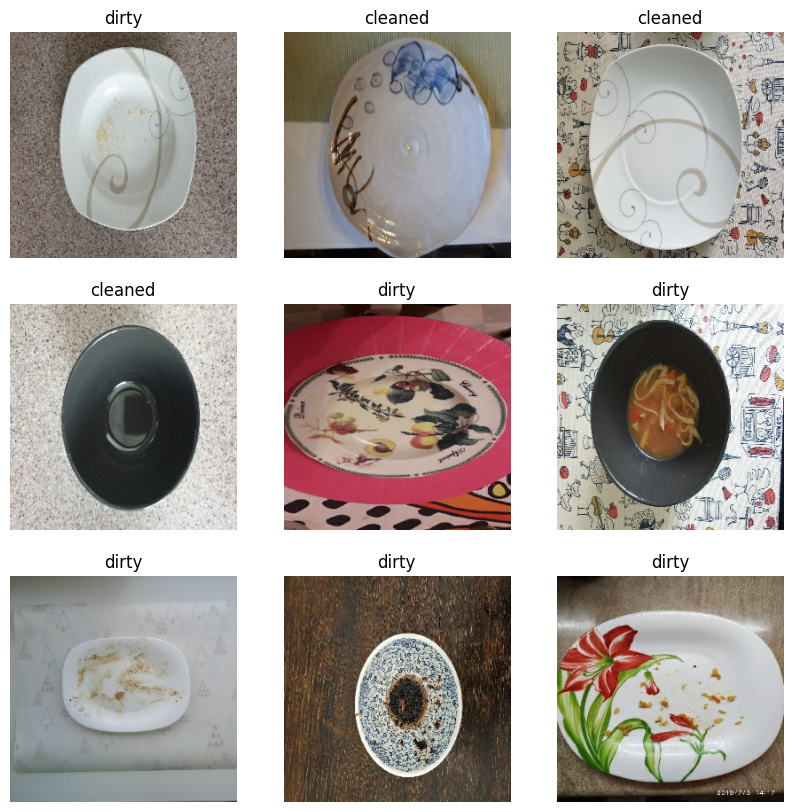

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Data Augmentation

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),  # Horizontal flip
        layers.RandomRotation(0.9),  # Increase rotation range
        layers.RandomZoom(0.2),  # Increase zoom level for more scale variations
        layers.RandomContrast(0.4),  # Keep contrast adjustment
        layers.RandomCrop(256, 256),  # Crop to 256x256
        layers.RandomTranslation(0.2, 0.2)  # Translate 20% of the image
    ]
)


## Base Model without Training

In [8]:
base_model = keras.applications.ResNet50(
    weights="imagenet", 
    input_shape=(img_height, img_width, 3),
    include_top=False,
)

base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(img_height, img_width, 3))
x = keras.applications.resnet.preprocess_input(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1)(x)
resnet50 = keras.Model(inputs, outputs)

resnet50.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.BinaryCrossentropy(from_logits=True), metrics=[keras.metrics.BinaryAccuracy()])
resnet50.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049  

In [9]:
from tensorflow.python.keras.callbacks import EarlyStopping

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 7)

hist = resnet50.fit(train_ds,
          validation_data=val_ds,
          epochs=500,
          callbacks=[cb_early_stopper])

Epoch 1/500
1/1 [==============================] - 5s 5s/step - loss: 0.8891 - binary_accuracy: 0.5312 - val_loss: 0.6767 - val_binary_accuracy: 0.6250
Epoch 2/500
1/1 [==============================] - 0s 145ms/step - loss: 0.8654 - binary_accuracy: 0.5312 - val_loss: 0.6735 - val_binary_accuracy: 0.5000
Epoch 3/500
1/1 [==============================] - 0s 145ms/step - loss: 0.8432 - binary_accuracy: 0.5312 - val_loss: 0.6713 - val_binary_accuracy: 0.5000
Epoch 4/500
1/1 [==============================] - 0s 145ms/step - loss: 0.8224 - binary_accuracy: 0.5312 - val_loss: 0.6702 - val_binary_accuracy: 0.5000
Epoch 5/500
1/1 [==============================] - 0s 144ms/step - loss: 0.8031 - binary_accuracy: 0.6250 - val_loss: 0.6701 - val_binary_accuracy: 0.5000
Epoch 6/500
1/1 [==============================] - 0s 148ms/step - loss: 0.7853 - binary_accuracy: 0.5938 - val_loss: 0.6709 - val_binary_accuracy: 0.5000
Epoch 7/500
1/1 [==============================] - 0s 145ms/step - loss: 

<Axes: >

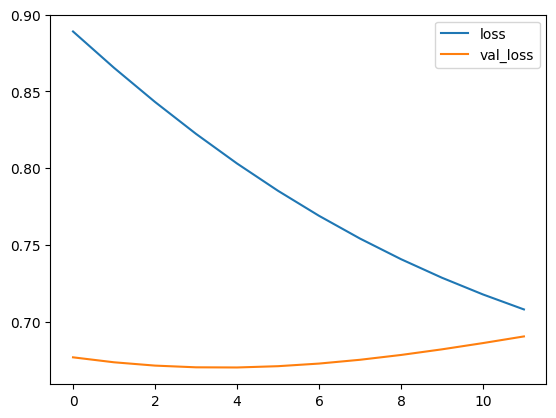

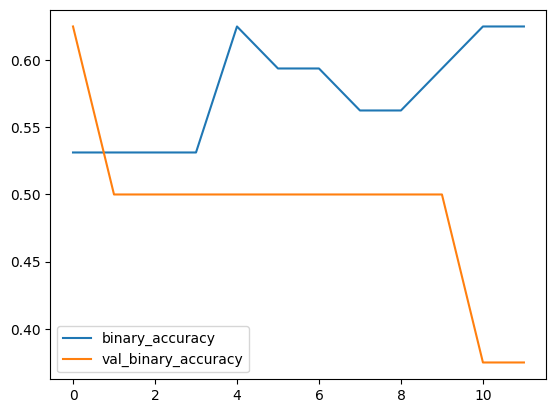

In [10]:
history_frame = pd.DataFrame(hist.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

## Build Deep Learning Model

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Rescaling
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import relu, elu
from tensorflow.keras import regularizers

In [12]:
model = Sequential()

# normalization layer
model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))

# Data augmentation layer
model.add(data_augmentation)

# model architecture
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(256, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(512, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

# Use GlobalAveragePooling2D instead of Flatten
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))  # Adding Dropout for regularization

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid')) # Sigmoid activation for binary classification

## Using Pretrained Models (Transfer Learning)

In [13]:
# Load a pretrained model (e.g., MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),
                                               include_top=False, 
                                               weights='imagenet') 

# Freeze the base model's layers
base_model.trainable = False

# Create a new model on top
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Adding Dropout for regularization
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

In [14]:
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [15]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainab

## Model training

In [16]:
# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

In [17]:
epochs=50

In [18]:
# Train the model
hist_2 = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.8779 - accuracy: 0.4375 - val_loss: 0.7181 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 2/50
1/1 [==============================] - 0s 269ms/step - loss: 0.9007 - accuracy: 0.3750 - val_loss: 0.7429 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 3/50
1/1 [==============================] - 0s 409ms/step - loss: 0.8162 - accuracy: 0.5000 - val_loss: 0.7793 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/50
1/1 [==============================] - 0s 112ms/step - loss: 0.7813 - accuracy: 0.4375 - val_loss: 0.8137 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/50
1/1 [==============================] - 0s 119ms/step - loss: 0.8803 - accuracy: 0.3750 - val_loss: 0.8315 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/50
1/1 [==============================] - 0s 95ms/step - loss: 0.7896 - accuracy: 0.5312 - val_loss: 0.8284 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 7/50
1/1 [==============================] - 0s 93ms/step - loss: 0.7096 - accura

## Plot Performance

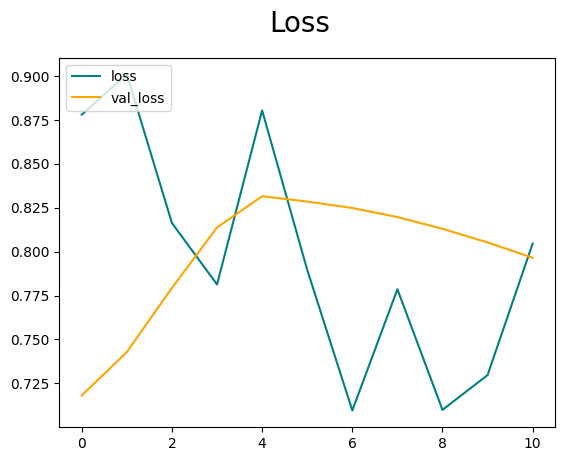

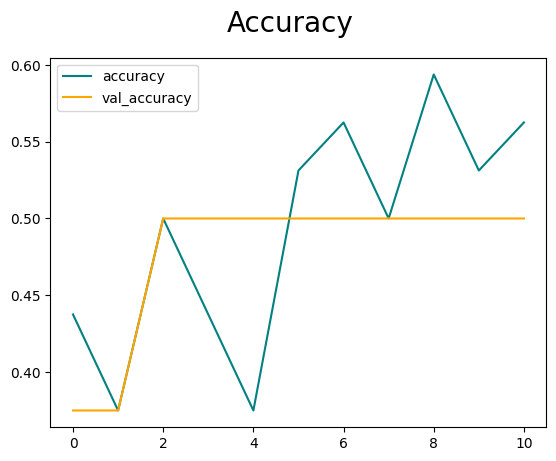

In [19]:
fig = plt.figure()
plt.plot(hist_2.history['loss'], color='teal', label='loss')
plt.plot(hist_2.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(hist_2.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_2.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Creating Submission

In [20]:
test_dir = 'data\\plates\\test'

In [21]:
# file names in the test directory
import os
test_files = os.listdir(test_dir)
print(test_files)

['0000.jpg', '0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg', '0005.jpg', '0006.jpg', '0007.jpg', '0008.jpg', '0009.jpg', '0010.jpg', '0011.jpg', '0012.jpg', '0013.jpg', '0014.jpg', '0015.jpg', '0016.jpg', '0017.jpg', '0018.jpg', '0019.jpg', '0020.jpg', '0021.jpg', '0022.jpg', '0023.jpg', '0024.jpg', '0025.jpg', '0026.jpg', '0027.jpg', '0028.jpg', '0029.jpg', '0030.jpg', '0031.jpg', '0032.jpg', '0033.jpg', '0034.jpg', '0035.jpg', '0036.jpg', '0037.jpg', '0038.jpg', '0039.jpg', '0040.jpg', '0041.jpg', '0042.jpg', '0043.jpg', '0044.jpg', '0045.jpg', '0046.jpg', '0047.jpg', '0048.jpg', '0049.jpg', '0050.jpg', '0051.jpg', '0052.jpg', '0053.jpg', '0054.jpg', '0055.jpg', '0056.jpg', '0057.jpg', '0058.jpg', '0059.jpg', '0060.jpg', '0061.jpg', '0062.jpg', '0063.jpg', '0064.jpg', '0065.jpg', '0066.jpg', '0067.jpg', '0068.jpg', '0069.jpg', '0070.jpg', '0071.jpg', '0072.jpg', '0073.jpg', '0074.jpg', '0075.jpg', '0076.jpg', '0077.jpg', '0078.jpg', '0079.jpg', '0080.jpg', '0081.jpg', '0082.jpg', '00

In [22]:
# file formats in the test directory
test_formats = [f.split('.')[-1] for f in test_files]
print(np.unique(test_formats))

['jpg']


In [23]:
# Load the test data without expecting labels
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    labels='inferred',  # Set to 'inferred' since we don't have labels
    label_mode=None,  # No labels, so set mode to None
    color_mode='rgb',  # Assuming RGB images
    shuffle=False  # No need to shuffle test data
)

Found 744 files belonging to 1 classes.


In [24]:
# Predict the test data
predictions = model.predict(test_ds)
print(predictions)

24/24 [==============================] - 1s 42ms/step
[[0.40628016]
 [0.3729577 ]
 [0.25829315]
 [0.27492872]
 [0.277281  ]
 [0.39878243]
 [0.3531105 ]
 [0.35417572]
 [0.23988923]
 [0.33235314]
 [0.34452745]
 [0.31500277]
 [0.35507768]
 [0.3134438 ]
 [0.4596098 ]
 [0.44461763]
 [0.38616973]
 [0.3589543 ]
 [0.37548357]
 [0.550211  ]
 [0.32890454]
 [0.30096063]
 [0.56996125]
 [0.35257095]
 [0.33823913]
 [0.38492942]
 [0.26111642]
 [0.46092853]
 [0.41448295]
 [0.33179668]
 [0.3501764 ]
 [0.3948869 ]
 [0.24206546]
 [0.2946225 ]
 [0.33011913]
 [0.30636543]
 [0.36976177]
 [0.34144345]
 [0.25733396]
 [0.36965513]
 [0.39760235]
 [0.21508092]
 [0.36994168]
 [0.2965339 ]
 [0.34382427]
 [0.31974334]
 [0.37539458]
 [0.2985978 ]
 [0.3608536 ]
 [0.25331718]
 [0.3296179 ]
 [0.3101076 ]
 [0.5624452 ]
 [0.54628354]
 [0.45616817]
 [0.4468962 ]
 [0.30369747]
 [0.48316932]
 [0.4471185 ]
 [0.3695462 ]
 [0.39066353]
 [0.35761708]
 [0.40395948]
 [0.3799952 ]
 [0.32908347]
 [0.32578966]
 [0.49792036]
 [0.3332

In [25]:
# Get the predicted class: 0 or 1
predicted_classes = (predictions > 0.5).astype("int32") # Convert boolean to 0 or 1
predicted_classes = predicted_classes.flatten() # Flatten to get a 1D array
print(predicted_classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 

In [26]:
# create a dataframe with filenames and predictions
df = pd.DataFrame({
    'id': [x.split('.')[0] for x in test_files],
    'label': ['dirty' if p == 1 else 'cleaned' for p in predicted_classes]
})
df.head()

,id,label
0,0000,cleaned
1,0001,cleaned
2,0002,cleaned
3,0003,cleaned
4,0004,cleaned


In [27]:
df.to_csv('predictions.csv', index=False)

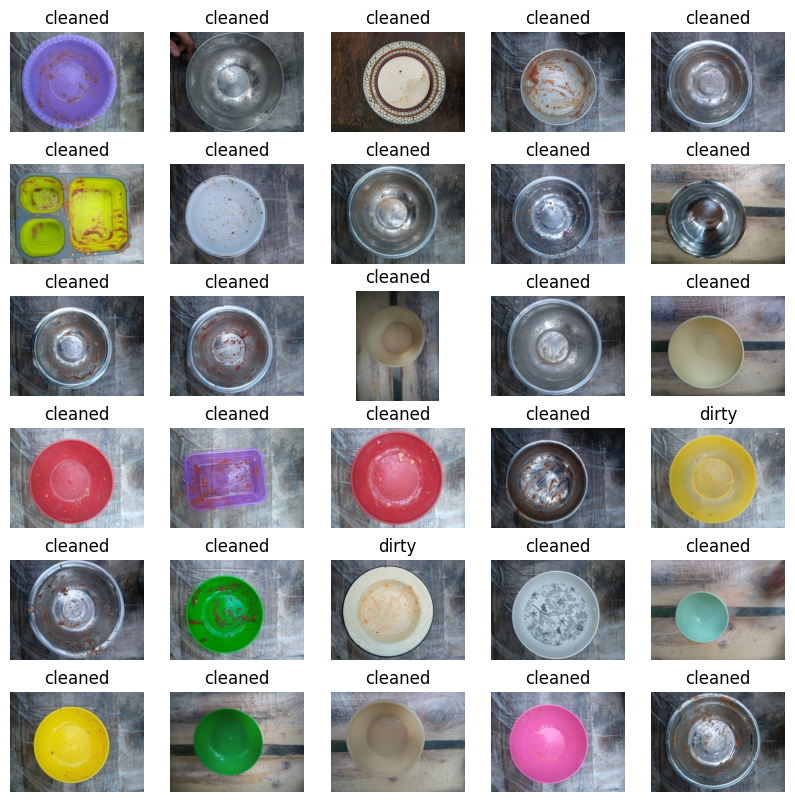

In [28]:
# plot 30 predictions images and their labels
plt.figure(figsize=(10, 10))
for i in range(30):
    ax = plt.subplot(6, 5, i + 1)
    plt.imshow(tf.keras.preprocessing.image.load_img(
        os.path.join(test_dir, test_files[i])
    ))
    plt.title(df['label'][i])
    plt.axis("off")
plt.show()


In [29]:
# make predictions using the resnet50 model
predictions_resnet50 = resnet50.predict(test_ds)
print(predictions_resnet50)

24/24 [==============================] - 3s 92ms/step
[[ 6.73971355e-01]
 [ 1.55562818e+00]
 [ 9.04072344e-01]
 [ 6.59954250e-01]
 [ 8.95454228e-01]
 [ 6.80316448e-01]
 [-1.93261579e-01]
 [ 9.31944370e-01]
 [ 1.55304980e+00]
 [-9.40474644e-02]
 [ 1.10984194e+00]
 [ 5.87887526e-01]
 [ 5.12976706e-01]
 [ 5.81846654e-01]
 [-7.38687336e-01]
 [ 8.40145826e-01]
 [ 2.86779314e-01]
 [-3.80038500e-01]
 [ 6.16254389e-01]
 [ 6.00446522e-01]
 [ 5.38382351e-01]
 [ 1.99113286e+00]
 [ 7.79556155e-01]
 [-9.54978243e-02]
 [-1.17772484e+00]
 [ 1.40616012e+00]
 [-4.99781221e-01]
 [ 4.56064999e-01]
 [ 6.76801726e-02]
 [ 1.60022533e+00]
 [-6.05983213e-02]
 [ 5.07410347e-01]
 [ 1.10803282e+00]
 [ 1.72052771e-01]
 [ 7.78204426e-02]
 [ 8.10952961e-01]
 [-1.29401517e+00]
 [ 8.51645708e-01]
 [ 6.32467866e-01]
 [ 2.16250396e+00]
 [ 1.12171614e+00]
 [ 9.19734299e-01]
 [ 1.80845284e+00]
 [-2.69020259e-01]
 [ 1.07598446e-01]
 [ 6.75669074e-01]
 [-1.03700794e-01]
 [ 1.51971197e+00]
 [ 8.92760336e-01]
 [ 7.58188367e-

In [30]:
# Get the predicted class: 0 or 1
predicted_classes_resnet50 = (predictions_resnet50 > 0.5).astype("int32") # Convert boolean to 0 or 1
predicted_classes_resnet50 = predicted_classes_resnet50.flatten() # Flatten to get a 1D array
print(predicted_classes_resnet50)

[1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 0 0 1 0 0 0 1 0 1 1 0 0 1 0
 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 1 0 0 0 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 1 0
 1 0 1 1 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1
 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 1 1 0 0 0 1 1 0
 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1 0 0 1 0
 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 1
 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 1 1 1 1 0 1 1 1 0 0 0 0 0 1
 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1
 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 1 1 1
 1 1 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 1 1
 0 0 1 0 1 1 1 1 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 1 0 1 0 0 1 1 1 0 0
 0 1 0 0 1 1 0 0 1 0 1 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 0 1
 1 1 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 1 1 0 0 1 1 0 1 1 1 0 1 

In [31]:
# create a dataframe with filenames and predictions
df_resnet50 = pd.DataFrame({
    'id': [x.split('.')[0] for x in test_files],
    'label': ['dirty' if p == 1 else 'cleaned' for p in predicted_classes_resnet50]
})
df_resnet50.head()

,id,label
0,0000,dirty
1,0001,dirty
2,0002,dirty
3,0003,dirty
4,0004,dirty


In [32]:
df_resnet50.to_csv('predictions_resnet50.csv', index=False)

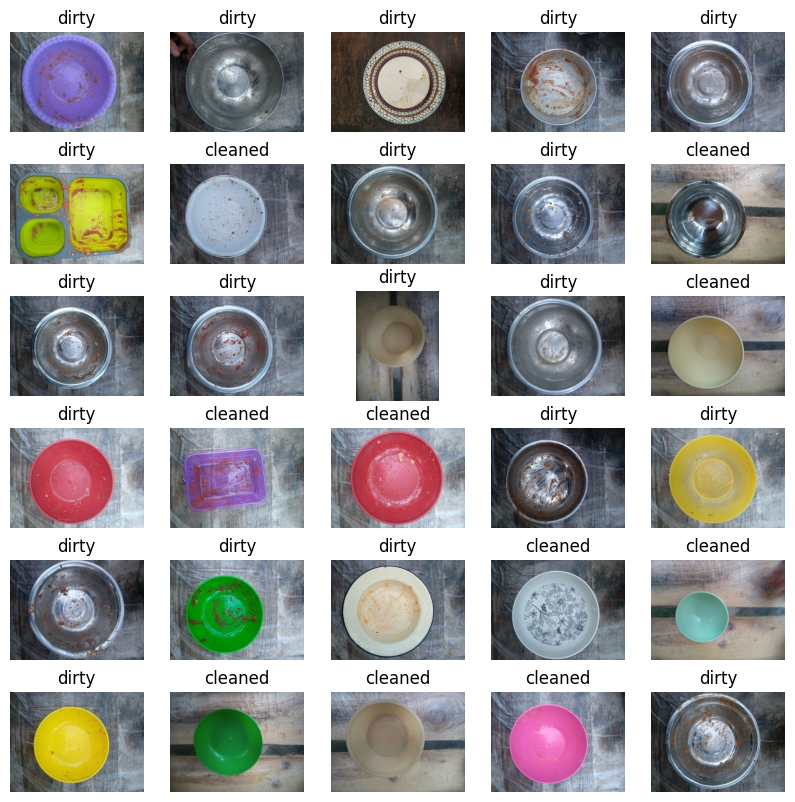

In [33]:
# plot 30 predictions images and their labels
plt.figure(figsize=(10, 10))
for i in range(30):
    ax = plt.subplot(6, 5, i + 1)
    plt.imshow(tf.keras.preprocessing.image.load_img(
        os.path.join(test_dir, test_files[i])
    ))
    plt.title(df_resnet50['label'][i])
    plt.axis("off")
plt.show()